In [9]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.integrate as integrate
from tqdm.auto import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
plt.style.use("default")
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.facecolor": "white",
    }
)

n_dense_points = 201

In [10]:
def Autonomous(t, y):
    """Autonomous Differential equation y' = 1.27*y*(1-y)
    """
    return 1.27*y*(1-y)

def Autonomous_exact(t, y0):
    return 1.0 / (1.0 + (1.0 / y0 - 1.0) * np.exp(-1.27 * t))

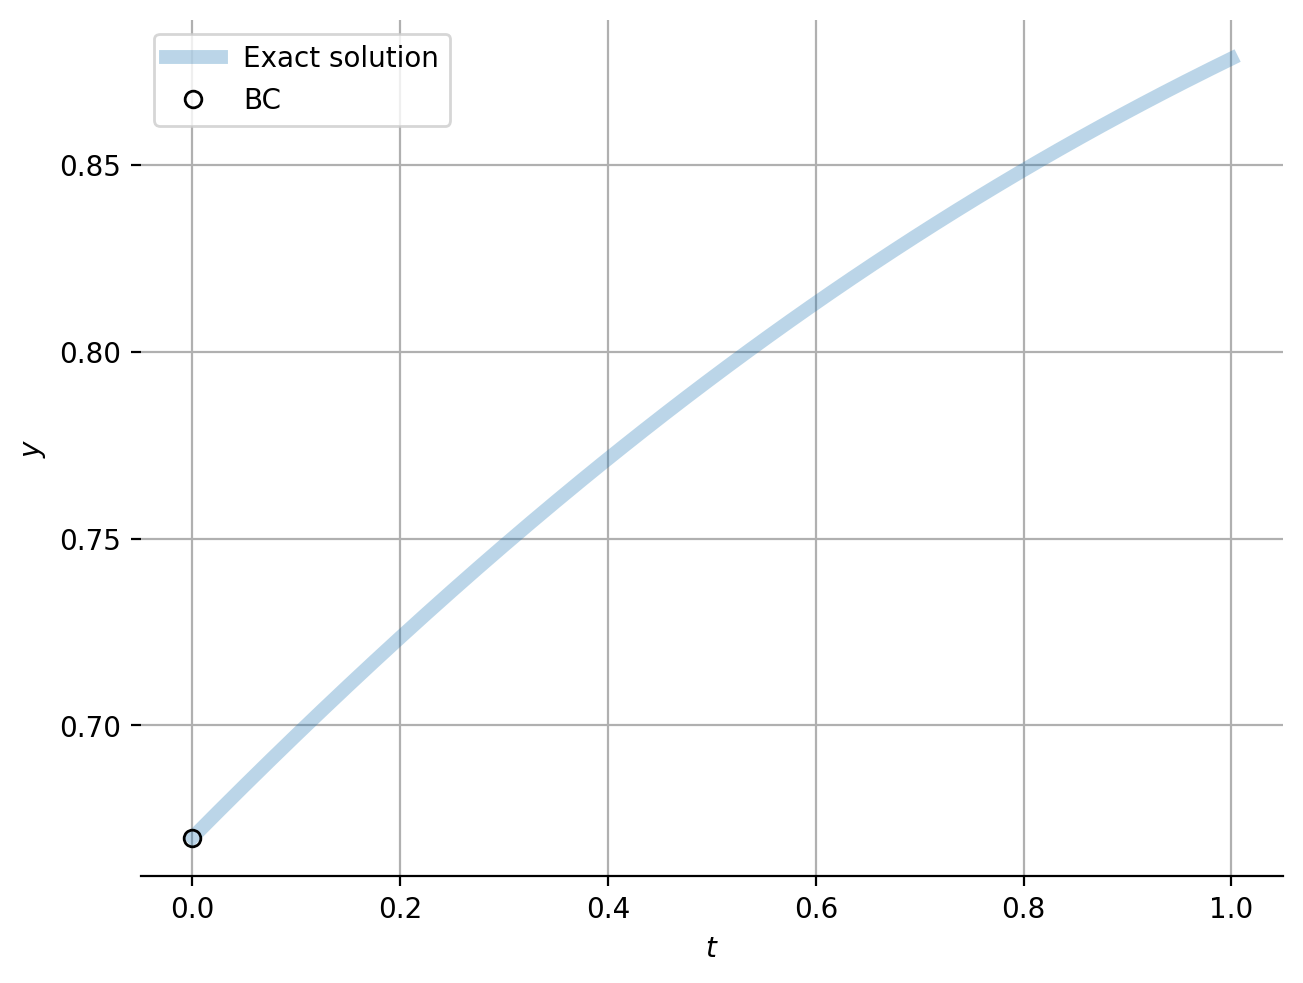

In [11]:
domain = (0, 1)
t0 = 0.0
y0 = 0.67

t_dense = np.linspace(*domain, n_dense_points)
y_exact = Autonomous_exact(t_dense, y0)

fig, ax = plt.subplots()
ax.plot(t_dense, y_exact, c="C0", linewidth=5, alpha=0.3, label="Exact solution")
ax.plot(t0, y0, "ko", mfc="none", label="BC")
ax.set(
    xlabel=r"$t$",
    ylabel=r"$y$",
)
ax.grid()
ax.legend()
ax.spines[["top", "right", "left"]].set_visible(False)

In [12]:
class MLP(nn.Module):
    def __init__(self, *features, activation=nn.Tanh):
        super().__init__()

        layers = []
        for in_features, out_features in zip(features, features[1:]):
            layers.append(nn.Linear(in_features, out_features))
            layers.append(activation())
        self.network = nn.Sequential(*layers[:-1])

    def forward(self, x):
        return self.network(x)

In [13]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

In [14]:
torch.manual_seed(78)
model = MLP(1, 16, 32, 1)
print(model)

MLP(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [15]:
batch_size = 10000
n_epochs = 2_000
print_interval = n_epochs // 10
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

loss_history = []
realloss_history=[]
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # 무작위 t 생성 후 y 계산
    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = model(t)
    y_e=1.0 / (1.0 + (1.0 / 0.67 - 1.0) * torch.exp(-1.27 * t))
    y_t = grad(y, t)

    # Loss
    loss_de = F.mse_loss(1.27*y*(1-y)- y_t, torch.zeros_like(y_t))
    loss_bc = F.mse_loss(model(torch.tensor([[t0]])), torch.tensor([[y0]]))
    loss = loss_de + loss_bc
    realloss=F.mse_loss(y-y_e, torch.zeros_like(y))**0.5
    # Backprop
    loss.backward()
    loss=loss_de**0.5+loss_bc**0.5
    optimizer.step()

    loss_history.append(loss.item())
    realloss_history.append(realloss.item())
    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_de = {loss_de.item():.4f}, loss_bc = {loss_bc.item():.4f}, loss = {loss.item():.4f}")


  0%|          | 0/2000 [00:00<?, ?it/s]

epoch = 0, loss_de = 0.0050, loss_bc = 0.2400, loss = 0.5603
epoch = 200, loss_de = 0.0000, loss_bc = 0.0000, loss = 0.0018
epoch = 400, loss_de = 0.0000, loss_bc = 0.0000, loss = 0.0015
epoch = 600, loss_de = 0.0000, loss_bc = 0.0000, loss = 0.0011
epoch = 800, loss_de = 0.0000, loss_bc = 0.0000, loss = 0.0008
epoch = 1000, loss_de = 0.0000, loss_bc = 0.0000, loss = 0.0006
epoch = 1200, loss_de = 0.0000, loss_bc = 0.0000, loss = 0.0004
epoch = 1400, loss_de = 0.0000, loss_bc = 0.0000, loss = 0.0004
epoch = 1600, loss_de = 0.0000, loss_bc = 0.0000, loss = 0.0004
epoch = 1800, loss_de = 0.0000, loss_bc = 0.0000, loss = 0.0004


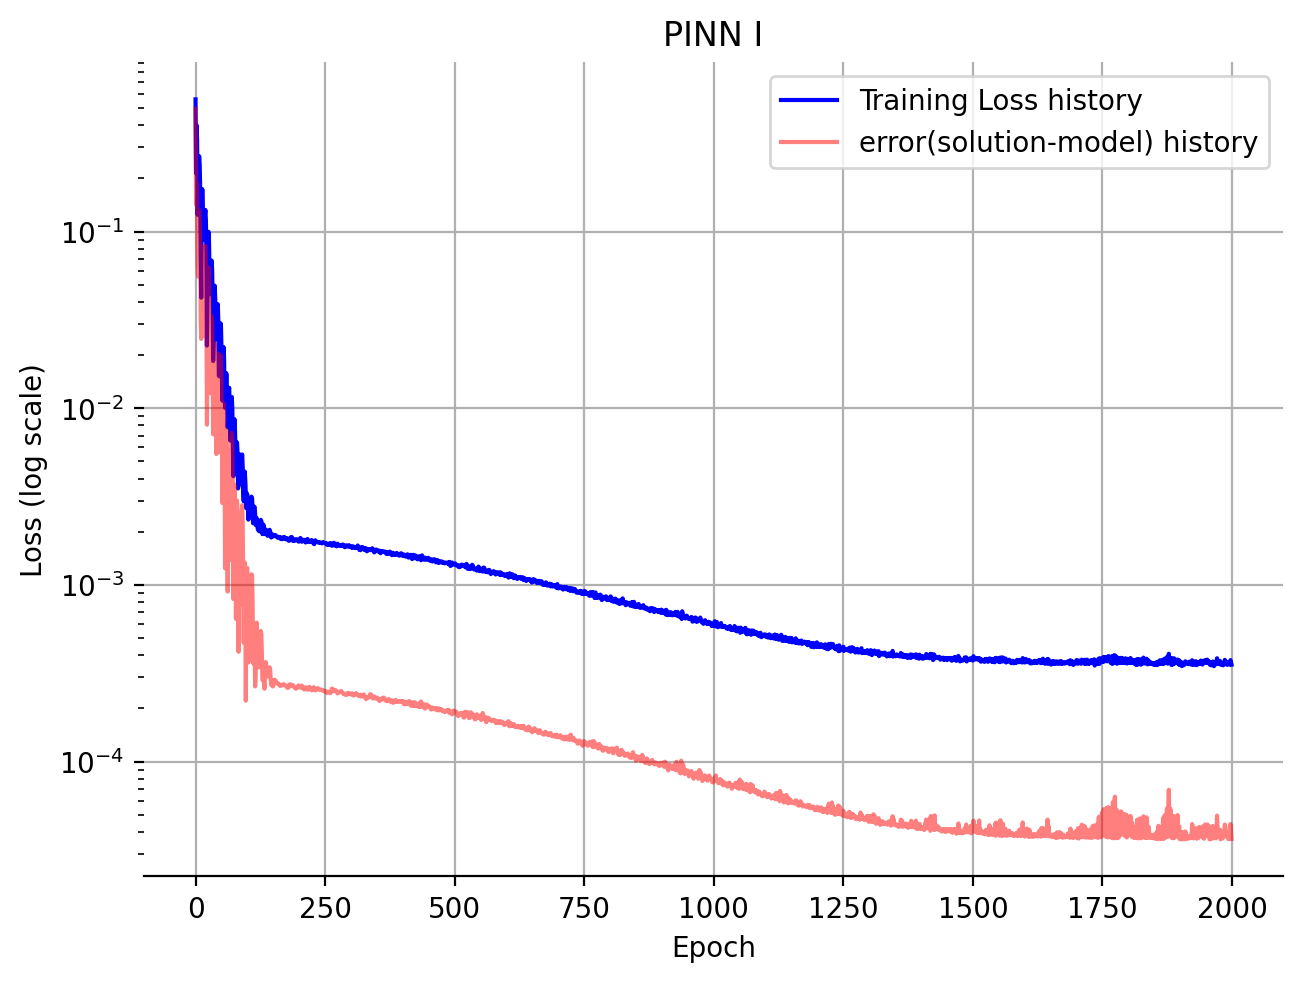

In [16]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "Training Loss history")
ax.plot(realloss_history,"r",alpha=0.5, label = "error(solution-model) history")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="Loss (log scale)",
    title = "PINN I"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass


In [17]:
X=np.array(loss_history)
Y=np.array(realloss_history)

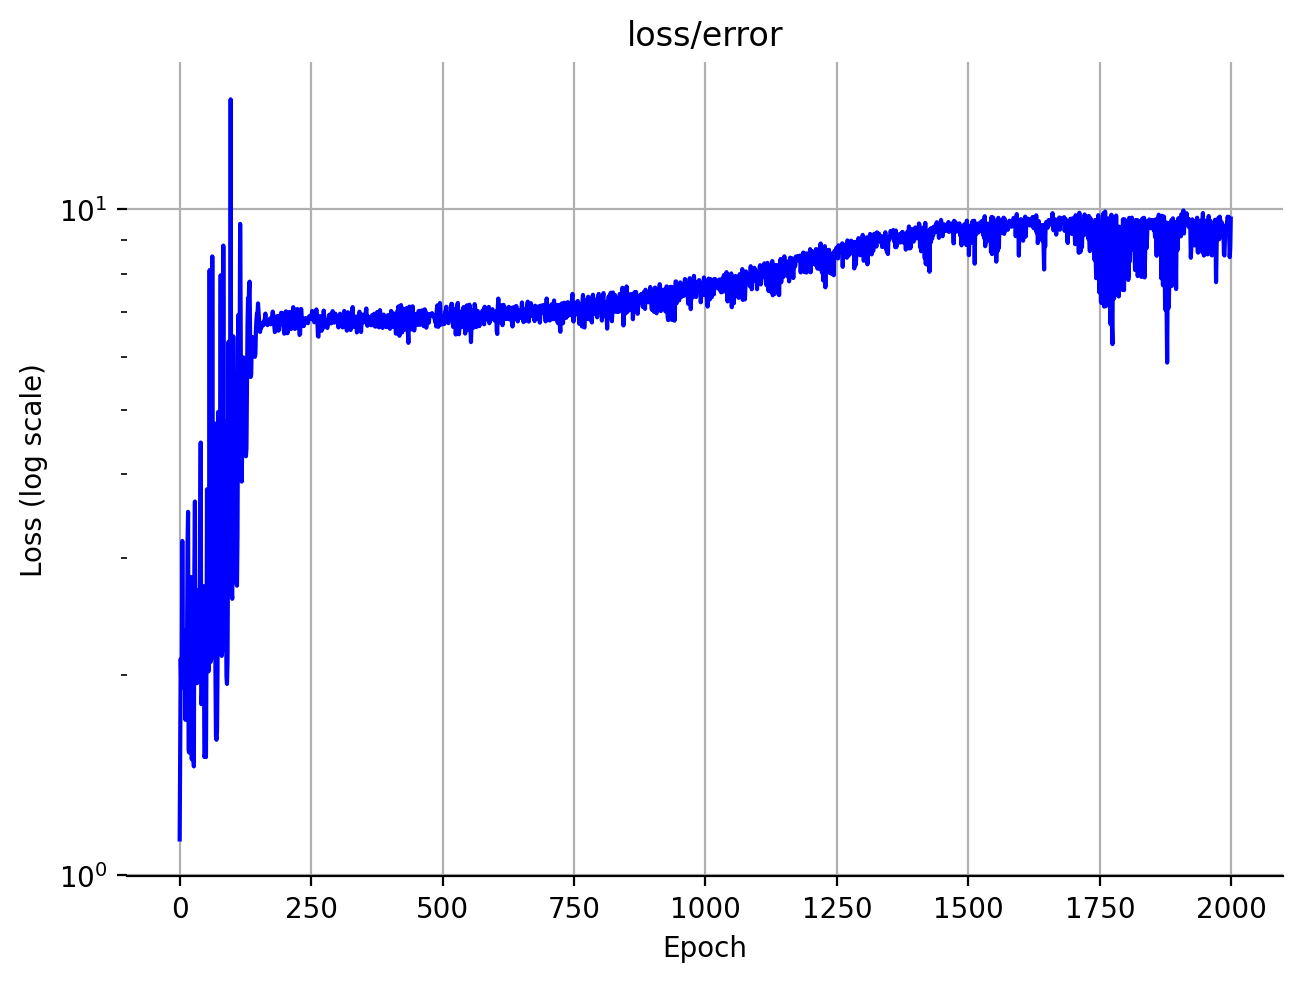

In [18]:
fig, ax = plt.subplots()
ax.plot(X/Y,"b")
# plt.axhline(1.0, 0, 1, color='C0', linestyle='--', linewidth=2)
ax.set(
    yscale="log",    ylabel="Loss (log scale)",    xlabel="Epoch",
    title="loss/error"
)
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

In [19]:
torch.manual_seed(78)
model = MLP(1, 16, 32, 1)

In [20]:
batch_size = 10000
n_epochs = 2_000
print_interval = n_epochs // 10
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

loss_history = []
realloss_history=[]
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # 무작위 t 생성 후 y 계산
    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = (t)*model(t)+0.67
    y_e= 1.0 / (1.0 + (1.0 / 0.67 - 1.0) * torch.exp(-1.27 * t))
    y_t = grad(y, t)

    # Loss
    loss_de = F.mse_loss(1.27*y*(1-y) - y_t, torch.zeros_like(y_t))
    loss = loss_de
    realloss=F.mse_loss(y-y_e, torch.zeros_like(y))
    # Backprop
    loss.backward()
    loss = loss_de**0.5
    optimizer.step()

    loss_history.append(loss.item())
    realloss_history.append(realloss.item())
    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_de = {loss_de.item():.4f}, loss = {loss.item():.4f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

epoch = 0, loss_de = 0.1000, loss = 0.3162
epoch = 200, loss_de = 0.0000, loss = 0.0012
epoch = 400, loss_de = 0.0000, loss = 0.0007
epoch = 600, loss_de = 0.0000, loss = 0.0005
epoch = 800, loss_de = 0.0000, loss = 0.0004
epoch = 1000, loss_de = 0.0000, loss = 0.0004
epoch = 1200, loss_de = 0.0000, loss = 0.0004
epoch = 1400, loss_de = 0.0000, loss = 0.0004
epoch = 1600, loss_de = 0.0000, loss = 0.0003
epoch = 1800, loss_de = 0.0000, loss = 0.0003


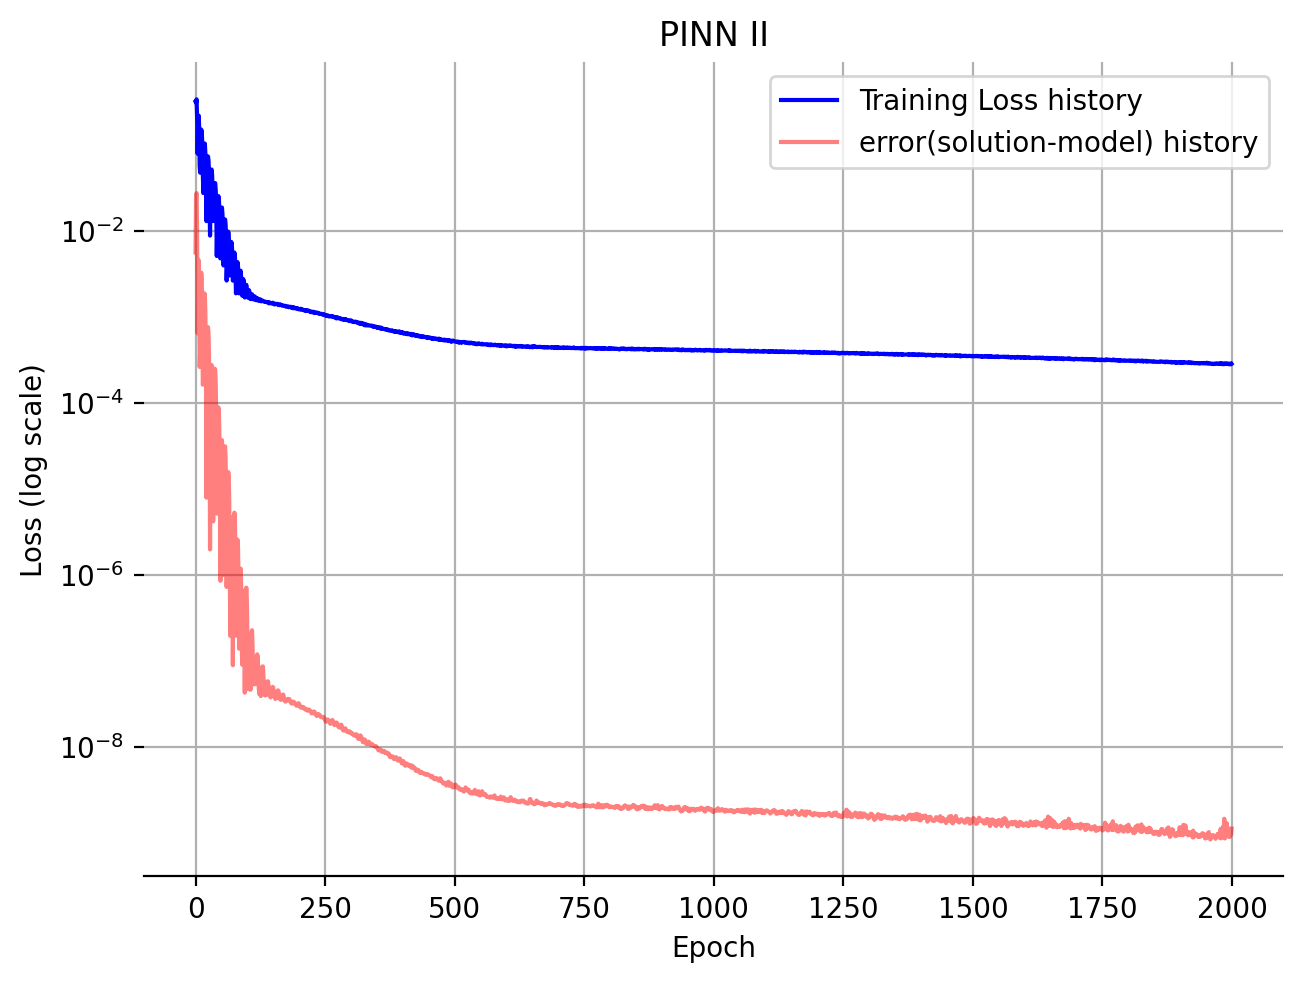

In [21]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "Training Loss history")
ax.plot(realloss_history,"r",alpha=0.5, label = "error(solution-model) history")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="Loss (log scale)",
    title = "PINN II"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass


In [22]:
X=np.array(loss_history)
Y=np.array(realloss_history)

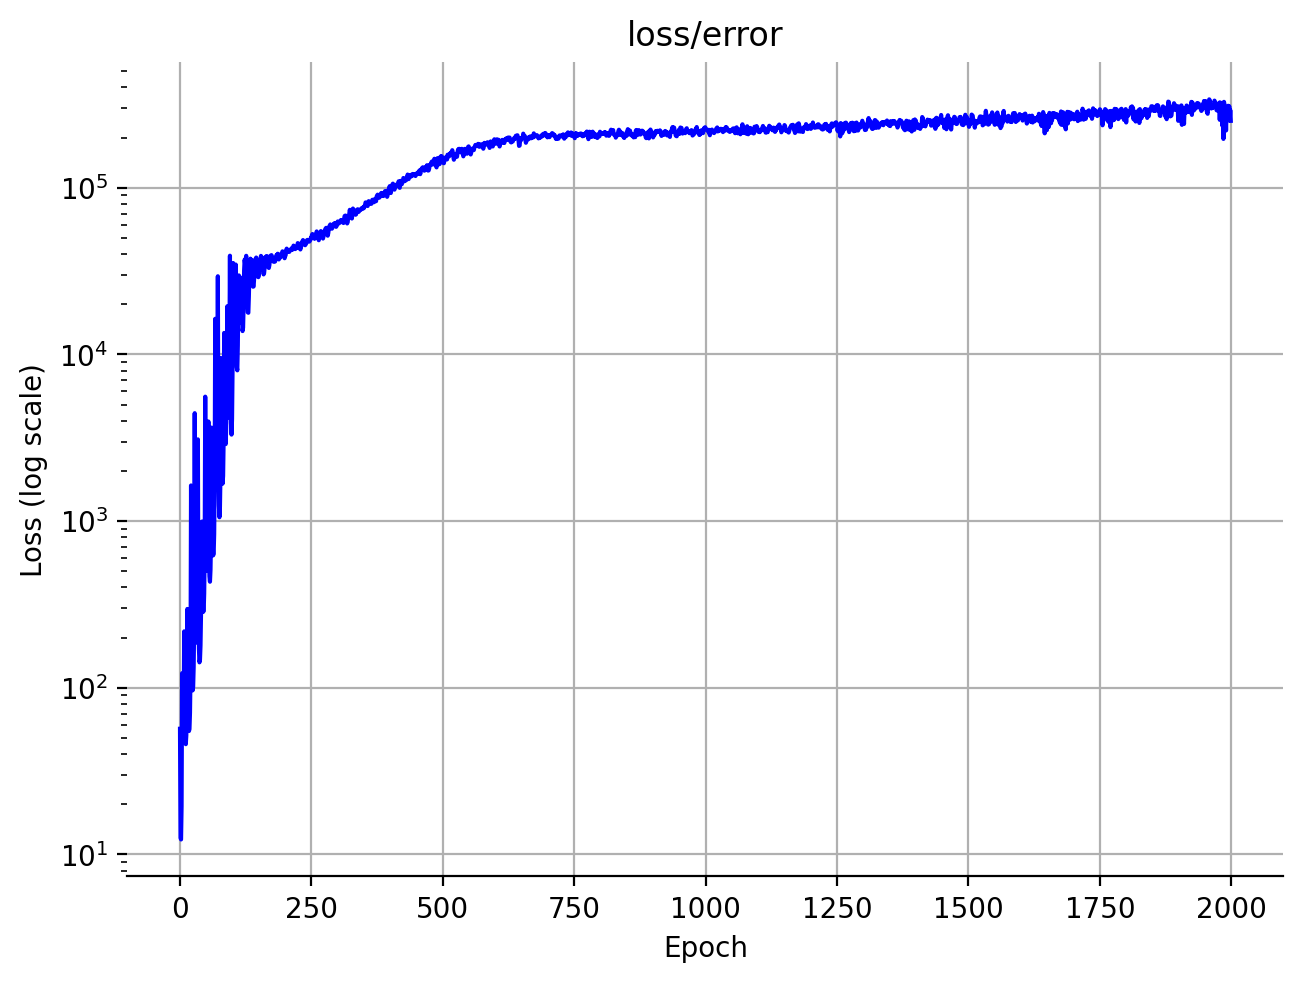

In [23]:
fig, ax = plt.subplots()
ax.plot(X/Y,"b")
# plt.axhline(1.0, 0, 1, color='C0', linestyle='--', linewidth=2)
ax.set(
    yscale="log",    ylabel="Loss (log scale)",    xlabel="Epoch",
    title="loss/error"
)
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass